# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import string


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from gensim.models import word2vec

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_hub as hub
import tensorflow_datasets as tfds


from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
 
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


import warnings
warnings.filterwarnings('ignore')

Version:  2.8.2
Hub version:  0.12.0
GPU is NOT AVAILABLE


# Functions We Use

In [ ]:
def transfer_model(module_url, embed_size, name, trainable=False):
 
    hub_layer = hub.KerasLayer(module_url, 
                               output_shape=[embed_size],
                               input_shape=[],    
                               dtype=tf.string, 
                               trainable = trainable)

    model = tf.keras.models.Sequential([                               
           hub_layer,
           tf.keras.layers.Dense(256, activation = "relu"), 
           tf.keras.layers.Dropout(0.3),                  
           tf.keras.layers.Dense(64, activation = "relu"),
           tf.keras.layers.Dropout(0.2),                        
           tf.keras.layers.Dense(1, activation  = "sigmoid")
                                             ])
    
  
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                  loss = tf.losses.BinaryCrossentropy(),
                  metrics = [tf.metrics.BinaryAccuracy(name = "accuracy")])
    
    model.summary()

    history = model.fit(X_train, y_train,
                        epochs = 100, batch_size = 32, 
                        validation_data = (X_test, y_test),
                        callbacks = [tfdocs.modeling.EpochDots(),
                                     tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, mode = "min"),
                                     tf.keras.callbacks.TensorBoard(logdir/name)],
                        verbose = 0)
    
    
    return history
  

In [ ]:
def new_cleaning(data):


    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")
    
    
    return cleaned_data

In [ ]:
def text_from_token(data):
    
    cleaned_sentence = " ".join(data)
    
    return  cleaned_sentence

In [ ]:
def acc_loss(model):
    
    
    train_loss = model.history["loss"]
    train_acc  = model.history["accuracy"]

    test_loss = model.history["val_loss"]
    test_acc  = model.history["val_accuracy"]

    train_test = [(train_loss, test_loss, "loss"), (train_acc,test_acc, "accuracy")]

    figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25,7))
    sns.set(font_scale=2)
    
  
    for i, item in enumerate(train_test):
        ax = axes[i]
        g = sns.lineplot(x = range(1, 1 + len(item[0])), y = item[0], label = "train_" + item[2], ax = ax);
        g = sns.lineplot(x = range(1, 1 + len(item[1])), y = item[1], label = "test_" + item[2], ax = ax);

In [ ]:
def print_results(model):
    
    cf_matrix_test  = confusion_matrix(y_test, np.rint(model.predict(X_test)))
    cf_matrix_train = confusion_matrix(y_train, np.rint(model.predict(X_train)))
    
    sns.set(font_scale= 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax1 = axes[0]
    
    g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', ax = ax1)
    
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    g = sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', ax = ax2)
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, np.rint(model.predict(X_train)), 
                                        output_dict = True)
    test_class  = classification_report(y_test, np.rint(model.predict(X_test)), 
                                        output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    return report

In [ ]:
model_urls = {}


model_urls[1] = {"model_name":"gnews-swivel-20dim", 
                 "embed_size": 20,
                 "url": "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"}

model_urls[2] = {"model_name":"nnlm-en-dim50", 
                 "embed_size": 50,
                 "url": "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"}

model_urls[3] = {"model_name":"nnlm-en-dim128", 
                 "embed_size": 128,
                 "url": "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"}

model_urls[4] = {"model_name":"universal-sentence-encoder", 
                 "embed_size": 512,
                 "url": "https://tfhub.dev/google/universal-sentence-encoder/4"}

model_urls[5] = {"model_name":"universal-sentence-encoder-large", 
                 "embed_size": 512,
                 "url": "https://tfhub.dev/google/universal-sentence-encoder-large/5"}

# Importing Data

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/train.csv")


data  = [train, test]

for df in data:
    
    df.drop("Unnamed: 0", axis = 1, inplace = True)
    df["cleaned"] =  df["cleaned"].apply(lambda x: new_cleaning(x))
    df["cleaned_text"] =  df["cleaned"].apply(lambda x: text_from_token(x))
    df["for_glove"] =  df["for_glove"].apply(lambda x: new_cleaning(x))
    df["cleaned_glove"] =  df["for_glove"].apply(lambda x: text_from_token(x)) 

print("DONE!")

DONE!


In [ ]:
train.head()

le = LabelEncoder()

X_train = train["cleaned_glove"].values
y_train = le.fit_transform(train["label"])

X_test = test["cleaned_glove"].values
y_test = le.transform(test["label"])

# Modeling

In [ ]:
histories = {}

## 1st Model: `gnews-swivel-20dim`

For this model, we use the embedding layer provided from [TensorFlow Hub](tfhub.dev). The model we use is `gnews-swivel-20dim` and the embedding file can be find [here](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1). Thi model is token based text embedding trained on English Google News 130GB corpus and it is published by Google. 

In [ ]:
i = 1

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

histories[model_name] = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 21,889
Non-train

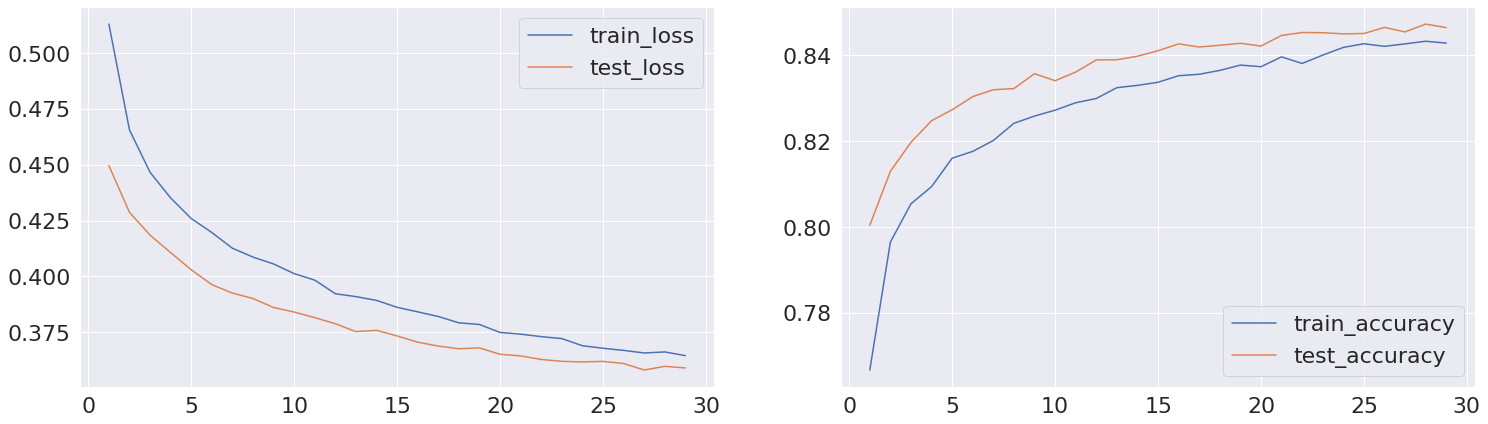

In [ ]:
acc_loss(histories[model_urls[1]["model_name"]])

## 2nd Model: `nnlm-en-dim50`

The second model we use is `nnlm-en-dim50` that we found on the [TensorFlow Hub](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) webpage.



In [ ]:
i = 2

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

histories[model_name] = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 256)               13056     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 29,569
Non-

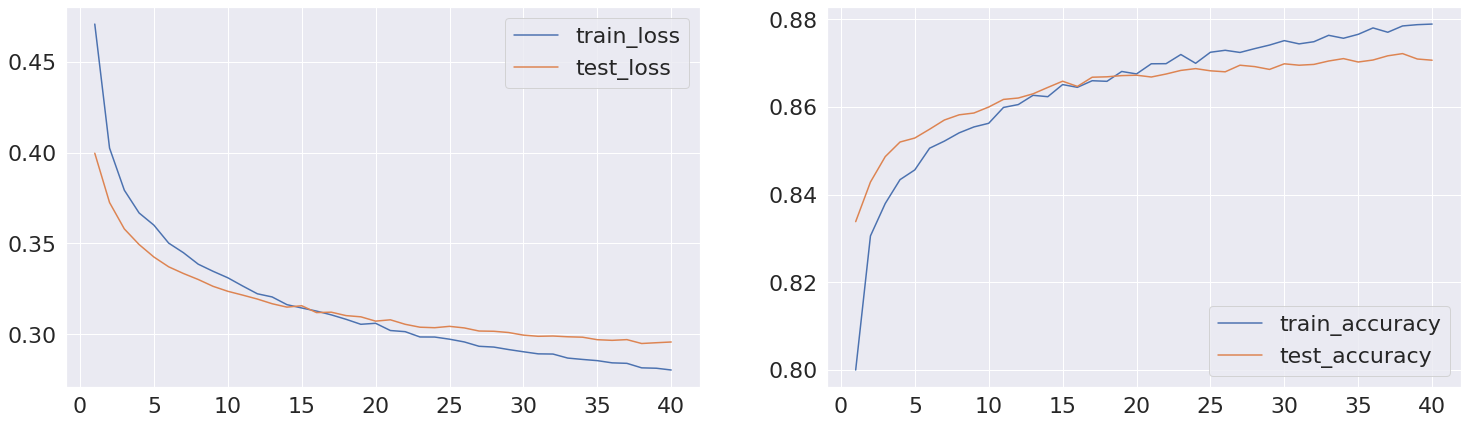

In [ ]:
acc_loss(histories[model_urls[2]["model_name"]])

## 3rd Model

In [ ]:
i = 3

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

histories[model_name] = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

print("DONE!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 49,537
Non

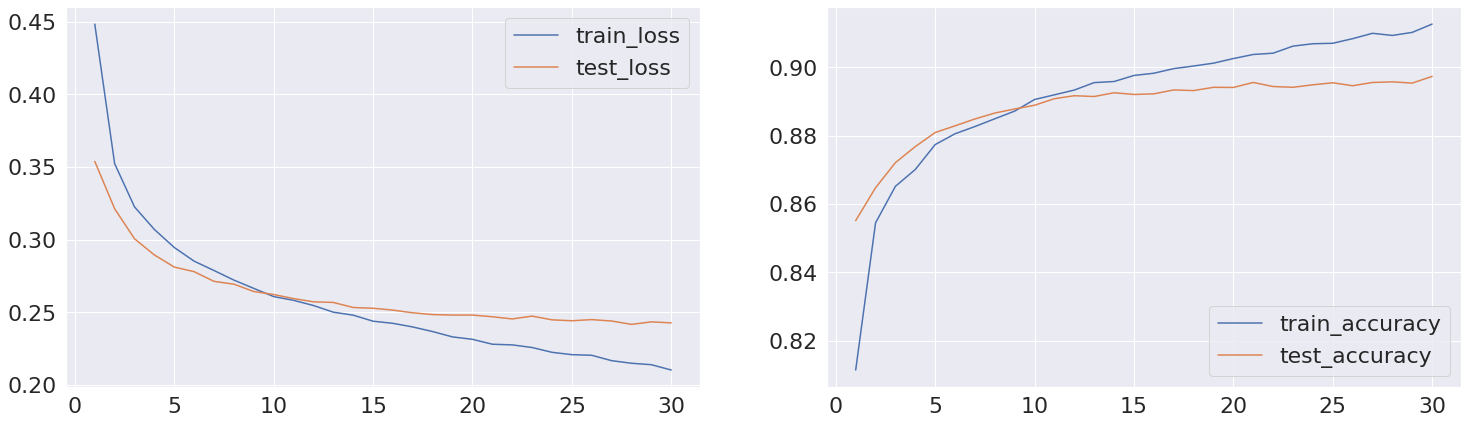

In [ ]:
acc_loss(histories[model_urls[3]["model_name"]])

In [ ]:
# histories[model_urls[3]["model_name"]].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 4th Model

In [ ]:
i = 4

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

histories[model_name] = transfer_model(module_url = url, embed_size = embed_size, 
                                       name = model_name, trainable = False)

print("DONE!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 147,841
No

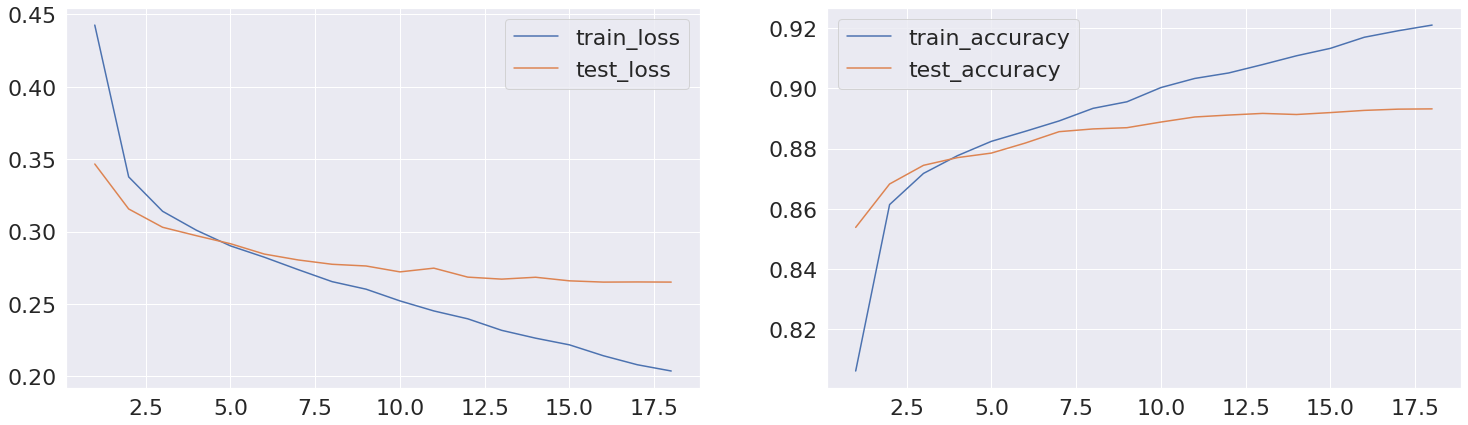

In [ ]:
acc_loss(histories[model_urls[4]["model_name"]])

In [ ]:
print_results(histories[model_urls[4]["model_name"]])

## 5th Model: Wiki-words-250

This model can be found [here](https://tfhub.dev/google/Wiki-words-250/2). It is a "Token based text embedding trained on English Wikipedia corpus" and it is published by Google. 

In [ ]:
url = "https://tfhub.dev/google/Wiki-words-250/2"

histories["Wiki-words-250"] = transfer_model(module_url = url, embed_size = 250,
                                       name = "Wiki-words-250", trainable = False)

NameError: ignored

# Comparison of Models

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

NameError: ignored

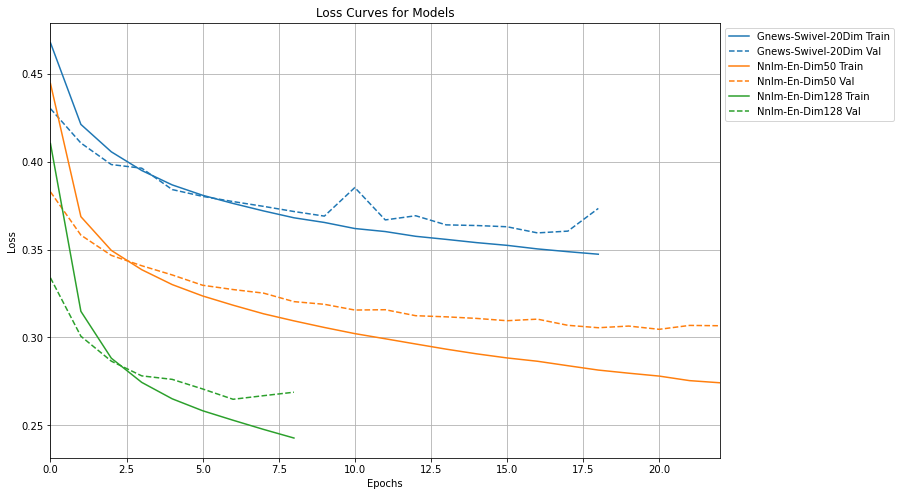

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()